In this notebook we will test whether Croissant recovers the sky temperature for some simple analytic beams with no horizon.

In [1]:
import croissant as cro

from astropy.units import s as seconds
import healpy as hp
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

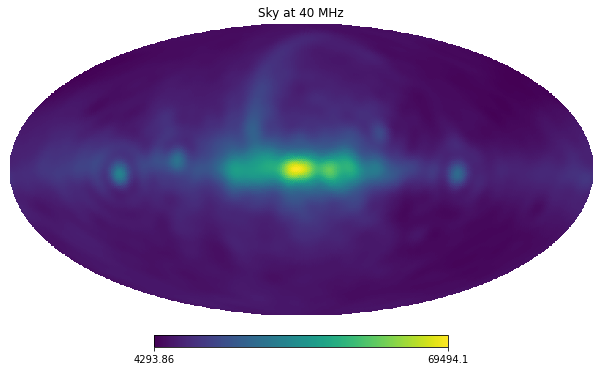

In [2]:
freq = np.linspace(40, 80, 41)
lmax = 32
nside = 64
sky = cro.Sky.gsm(freq, lmax=lmax)
hp.mollview(sky.hp_map(nside)[0], title=f"Sky at {freq[0]:.0f} MHz")

## Uniform beam

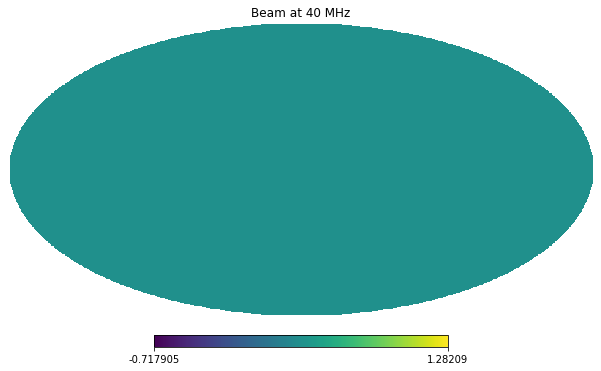

In [3]:
beam_alm = np.zeros((freq.size, hp.Alm.getsize(lmax)))
beam = cro.Beam(beam_alm, lmax=lmax, frequencies=freq, coord="T")

# set (l=0, m=0) and (l=1, m=0) mode
beam[:, 0, 0] = 1
hp.mollview(beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")

In [4]:
# full sidereal day on the earth
loc = (122.27, 37.87)
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
sim = cro.Simulator(beam, sky, loc, t_start, world="earth", t_end=t_end, N_times=300, lmax=lmax)

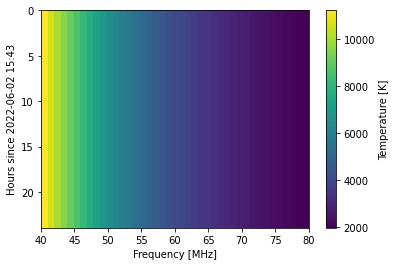

In [5]:
sim.run(dpss=False)
sim.plot()

With a uniform beam we should simply recover the mean sky temperature. In the language of spherical harmonics, the mean sky temperature is given by
$$<T_{\rm sky}> = a_{00} Y_0^0,$$ i.e. the (0,0)-mode of the spherical harmonics decomposition.

In [6]:
# there's no time dependence for the uniform beam
np.allclose(sim.waterfall, sim.waterfall[0])

True

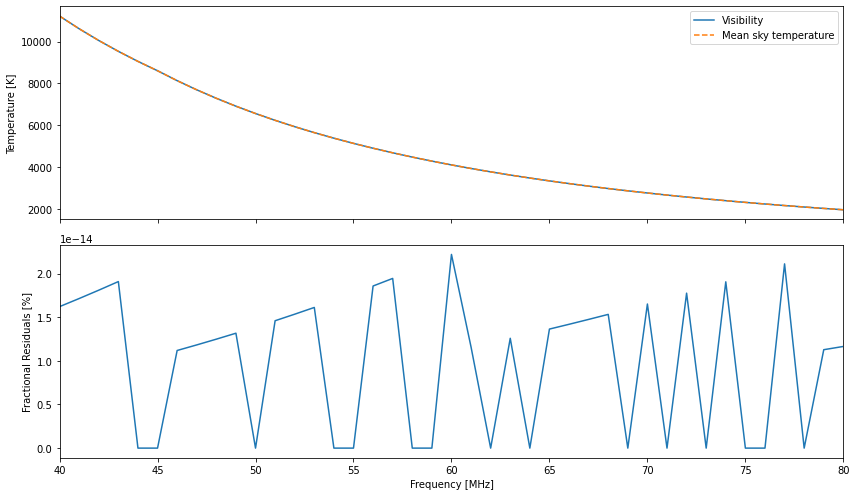

In [7]:
mean_sky = sim.sky[:, 0, 0].real * cro.constants.Y00  # a00 Y00

fig, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True)
axs[0].plot(sim.frequencies, sim.waterfall[0], label="Visibility")
axs[0].plot(sky.frequencies, mean_sky, ls="--", label="Mean sky temperature")
axs[0].set_ylabel("Temperature [K]")
axs[0].legend()
axs[1].plot(sim.frequencies, (sim.waterfall[0] - mean_sky) / sim.waterfall[0] * 100)
axs[1].set_ylabel("Fractional Residuals [%]")
axs[1].set_xlabel("Frequency [MHz]")
plt.setp(axs, xlim=(sim.frequencies.min(), sim.frequencies.max()))
plt.tight_layout()
plt.show()

In [8]:
# we get the same result on the moon
t_end_moon = t_start + cro.constants.sidereal_day_moon * seconds
sim_moon = cro.Simulator(beam, sky, loc, t_start, world="moon", t_end=t_end_moon, N_times=300, lmax=lmax)
sim_moon.run(dpss=False)
np.allclose(sim.waterfall, sim_moon.waterfall)

True

## Dipole beam

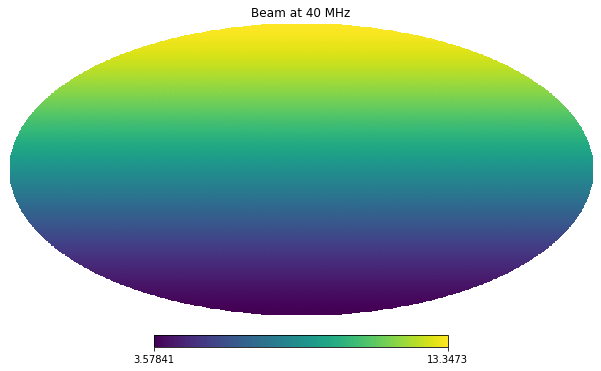

In [9]:
beam_alm = np.zeros((freq.size, hp.Alm.getsize(lmax)))
beam = cro.Beam(beam_alm, lmax=lmax, frequencies=freq, coord="C")
beam[:, 0, 0] = 30 * (freq/freq[0]) ** 2
beam[:, 1, 0] = 10 * (freq/freq[0])**2
hp.mollview(beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")

In [10]:
# run the simulation with all the same parameters
sim = cro.Simulator(beam, sky, loc, t_start, world="earth", t_end=t_end, N_times=300, lmax=lmax)

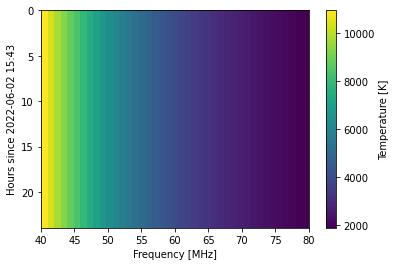

In [11]:
sim.run(dpss=False)
sim.plot()

A dipole beam should pick out the (0, 0) and (1, 0) modes of the sky. These are symmetric about the rotation axis of earth, hence there should be no time dependence.

In [12]:
np.allclose(sim.waterfall[0], sim.waterfall)  # no change with time

True

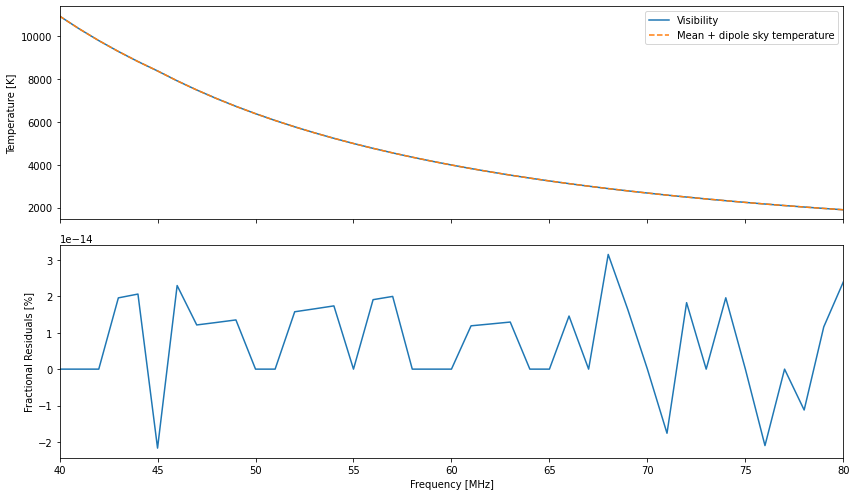

In [13]:
# the visibility is the mean sky temperature (as before) + the dipole contribution
dipole_sky = sim.sky[:, 1, 0].real * sim.beam[:, 1, 0].real  # perceived sky, dot product between sky and beam
dipole_sky /= sim.beam.total_power  # normalized by beam power

fig, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True)
axs[0].plot(sim.frequencies, sim.waterfall[0], label="Visibility")
axs[0].plot(sky.frequencies, mean_sky + dipole_sky, ls="--", label="Mean + dipole sky temperature")
axs[0].set_ylabel("Temperature [K]")
axs[0].legend()
axs[1].plot(sim.frequencies, (sim.waterfall[0] - (mean_sky + dipole_sky)) / sim.waterfall[0] * 100)
axs[1].set_ylabel("Fractional Residuals [%]")
axs[1].set_xlabel("Frequency [MHz]")
plt.setp(axs, xlim=(sim.frequencies.min(), sim.frequencies.max()))
plt.tight_layout()
plt.show()

In [14]:
np.allclose(sim.waterfall[0], mean_sky + dipole_sky)

True